# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [41]:
# imports
from dotenv import load_dotenv
from panel import widgets
from panel.interact import interact
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
import os
import pandas as pd
import panel as pn
import plotly.express as px
pn.extension()
pn.extension('plotly')

%matplotlib inline

In [42]:
# Read the Mapbox API key
load_dotenv()
mapbox_token = os.getenv("MAPBOX_API_KEY")

# Import Data

In [43]:
# Import the CSVs to Pandas DataFrames
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")

file_path = Path("Data/neighborhoods_coordinates.csv")
df_neighborhood_locations = pd.read_csv(file_path)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [44]:
# Calculations
mean_housing_units = sfo_data.groupby(["year"])["housing_units"].mean()
mean_gross_rent              = sfo_data.groupby(["year"])["gross_rent"].mean()
mean_sale_price_per_sqr_foot = sfo_data.groupby(["year"])["sale_price_sqr_foot"].mean()
sfo_grouped_by_year_and_nbhd = sfo_data.groupby(["year", "neighborhood"]).mean()
sfo_grouped_by_year_and_nbhd.reset_index(inplace=True)
top_10 = sfo_data.groupby(["neighborhood"]).mean() \
    .sort_values(by="sale_price_sqr_foot", ascending=False).head(10)
top_10.reset_index(inplace=True)


# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""

    mean_housing_units = sfo_data.groupby(["year"])["housing_units"].mean()

    sfo_grouped_min = sfo_data.groupby(["year"])["housing_units"].min().min()
    sfo_grouped_max = sfo_data.groupby(["year"])["housing_units"].max().max()
    sfo_grouped_std = sfo_data["housing_units"].std()

    first_year = mean_housing_units.index[0]
    last_year = mean_housing_units.index[-1]

    fig_housing_units = mean_housing_units.plot.bar(
        xlim=[first_year, last_year],
        ylim=[sfo_grouped_min - sfo_grouped_std, sfo_grouped_max + sfo_grouped_std]
    )
    fig_housing_units.set_title("Housing Units in San Franscisco from 2010 to 2016")
    fig_housing_units.set_xlabel("Year")
    fig_housing_units.set_ylabel("Nbr. Housing Units")

    return fig_housing_units


def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""

    fig_gross_rent = mean_gross_rent.plot.line()
    fig_gross_rent.set_title("Average Gross Rent in San Francisco")
    fig_gross_rent.set_xlabel("Year")
    fig_gross_rent.set_ylabel("Gross Rent")

    return fig_gross_rent


def average_sales_price():
    """Average Sales Price Per Year."""
    

    fig_sale_price_per_sqr_foot = mean_sale_price_per_sqr_foot.plot.line()
    #xlim=[first_year, last_year])
    fig_sale_price_per_sqr_foot.set_title("Average Sale Price per Square Foot in San Francisco")
    fig_sale_price_per_sqr_foot.set_xlabel("Year")
    fig_sale_price_per_sqr_foot.set_ylabel("Avg. Sale Price")

    return fig_sale_price_per_sqr_foot


def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""

    neighborhoods = sfo_grouped_by_year_and_nbhd["neighborhood"]

    def plot_avg_price_per_sq_ft(neighborhood):
        print(neighborhood)
        return sfo_grouped_by_year_and_nbhd.loc[neighborhoods == neighborhood, "sale_price_sqr_foot"].plot.line()

    figure_panel = pn.panel(interact(plot_avg_price_per_sq_ft, neighborhood=neighborhoods))
    return figure_panel


def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""

    return top_10.hvplot.bar(
        x="neighborhood",
        y="sale_price_sqr_foot",
        title="Top 10 Expensive Neighborhoods in SFO",
        xlabel="Neighborhood",
        ylabel="Avg. Sale Price per Square Foot",
        width=600,
        height=350)


def parallel_coordinates():
    """Parallel Coordinates Plot."""

    return px.parallel_coordinates(top_10, color = "sale_price_sqr_foot", width=900)


def parallel_categories():
    """Parallel Categories Plot."""

    return px.parallel_categories(top_10, color = "sale_price_sqr_foot", width=900)


def neighborhood_map():
    """Neighborhood Map"""

    file_path = Path("Data/neighborhoods_coordinates.csv")
    df_neighborhood_locations = pd.read_csv(file_path)
    df_neighborhood_locations.columns = [ "neighborhood", "Lat", "Lon" ]
    
    mean_data = sfo_data.groupby("neighborhood").mean()
    mean_data.reset_index(inplace=True)

    combined_data = pd.concat([df_neighborhood_locations, mean_data], axis='columns', join='inner')
    combined_data = combined_data.iloc[:, 1:]

    px.set_mapbox_access_token(mapbox_token)
    map = px.scatter_mapbox(
        combined_data,
        lat="Lat",
        lon="Lon",
        size="gross_rent",
        color="neighborhood"
    )
    return map.show()

## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

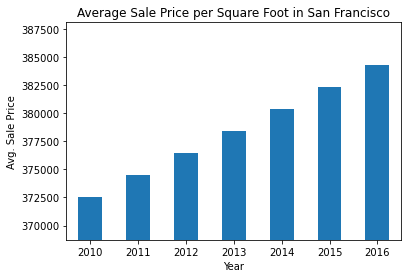

In [45]:
## NOTE: Build rows and colums here.

row1 = pn.Column("# Row 1", housing_units_per_year(), average_gross_rent(), average_sales_price())
#row2 = pn.Row("# Row 2", average_price_by_neighborhood(), top_most_expensive_neighborhoods(), parallel_coordinates())
#row3 = pn.Row("# Row 3", parallel_categories(), neighborhood_map())

#plots_as_column = pn.Column("# Rental Dashboard Column", row1, row2)

## NOTE: Build dashboard here.

dashboard = pn.Tabs(
    ("Plots 1", row1),
#    ("Plots 2", row2),
#    ("Plots 3", row3)
)

#dashboard

## Serve the Panel Dashboard

In [46]:
dashboard.servable()

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Str(AxesSubplot)
        [2] Str(AxesSubplot)
        [3] Str(AxesSubplot)